# General: Brightness / Luminosity of HII regions

In [1]:
%matplotlib inline
from astropy import units as u
import radio_beam
import pylab as pl
from dust_emissivity import dust
from constants import frequency as cfreq, distance

In [2]:
def dens(Qlyc=1e45*u.s**-1, R=0.1*u.pc, alpha_b=2e-13*u.cm**3*u.s**-1):
    return (((3 * Qlyc)/(4 * np.pi * R**3 * alpha_b))**0.5).to(u.cm**-3)

def EM(Qlyc=1e45*u.s**-1, R=0.1*u.pc, alpha_b=2e-13*u.cm**3*u.s**-1):
    return (R * (((3 * Qlyc)/(4 * np.pi * R**3 * alpha_b))**0.5)**2).to(u.cm**-6*u.pc)

def tau(nu, EM, Te=7000*u.K):
    return 3.28e-7 * (Te/(1e4*u.K))**-1.35 * (nu/u.GHz)**-2.1 * (EM/(u.cm**-6*u.pc))

def Tb(Te=7000*u.K, nu=cfreq, EM=EM()):
    return Te * (1-np.exp(-tau(nu=nu, EM=EM, Te=Te)))
    #return (8.235e-2 * (Te/(u.K))**-0.35 * (nu/u.GHz)**-2.1 * (EM/u.cm**-6/u.pc)*u.K).to(u.K)

def Tb_beamdiluted(Te=7000*u.K, nu=cfreq, R=0.1*u.pc, Qlyc=1e45*u.s**-1, beam=4000*u.au):
    tb = Tb(Te=Te, nu=nu, EM=EM(R=R, Qlyc=Qlyc))
    if beam < R:
        return tb
    else:
        return (tb * (R/beam)**2).to(u.K)

def Snu(Te=7000*u.K, nu=cfreq, R=0.1*u.pc, Qlyc=1e45*u.s**-1, beam=4000*u.au,
        angular_beam=0.5*u.arcsec, cfreq=cfreq):
    tb = Tb(Te=Te, nu=nu, EM=EM(R=R, Qlyc=Qlyc))
    if beam < R:
        return tb.to(u.mJy, u.brightness_temperature(radio_beam.Beam(angular_beam), cfreq))
    else:
        return (tb * (R/beam)**2).to(u.mJy, u.brightness_temperature(radio_beam.Beam(angular_beam), cfreq))

def snu_dust(density=1e4*u.cm**-3, Td=40*u.K, radius=4000*u.au, distance=distance, cfreq=cfreq):
    mass = (density * 2.8 * u.Da * 4/3. * radius**3).to(u.M_sun)
    print(mass)
    beam = radio_beam.Beam((radius/distance).to(u.arcsec,u.dimensionless_angles()))
    flux = dust.snuofmass(nu=cfreq, mass=mass, beamomega=beam, temperature=Td, distance=distance)
    return flux
    

From 4.60 + 4.61 of http://www.cv.nrao.edu/~sransom/web/Ch4.html

Where does 4.67 come from?  It's mJy, apparently?  I can't reproduce that from anything.

$$S_{\nu} = 4.67 \left[1-\exp\left(-3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{EM}{\mathrm{cm}^{-6}\mathrm{pc}} \right) \right]$$

$$T_{B,\nu} = T_e \left[1-\exp\left(-3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{EM}{\mathrm{cm}^{-6}\mathrm{pc}} \right) \right]$$

$$EM = R n_h^2 = \frac{3 Q_{lyc}}{4 \pi R^2 \alpha_b}$$

$$Q_{lyc}(S_{\nu})$$

$$EM = (-3.28\times10^{-7})^{-1} \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} \ln\left(1-\frac{S_{\nu}}{4.67 \mathrm{mJy}}\right) \mathrm{cm}^{-6}~\mathrm{pc}$$

$$EM = (-3.28\times10^{-7})^{-1} \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} \ln\left(1-\frac{T_{B,\nu}}{T_e}\right) \mathrm{cm}^{-6}~\mathrm{pc}$$

$$Q_{lyc} = \frac{4}{3} \pi R^2 \alpha_b (-3.28\times10^{-7})^{-1} \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} \ln\left(1-\frac{T_{B,\nu}}{T_e}\right) \mathrm{s}^{-1}$$

$$(-3.28\times10^{-7}) \frac{Q_{lyc}}{ \mathrm{s}^{-1}} \left( \frac{4}{3} \pi R^2 \alpha_b\right)^{-1}\left[ \ln\left(1-\frac{T_{B,\nu}}{T_e}\right)\right]^{-1} =  \left(\frac{T_e}{10^4\mathrm{K}}\right)^{1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{2.1} $$

$$S_{\nu}(Q_{lyc})  = 4.67 \left[1-\exp\left(-3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{3 Q_{lyc}}{4 \pi R^2 \alpha_b} \right) \right]$$

$$S_{\nu}(Q_{lyc})  \approx 4.67 \left(3.28\times10^{-7} \left(\frac{T_e}{10^4 \mathrm{K}}\right)^{-1.35} \left(\frac{\nu}{\mathrm{GHz}}\right)^{-2.1} \frac{3 Q_{lyc}}{4 \pi R^2 \alpha_b} \right) $$

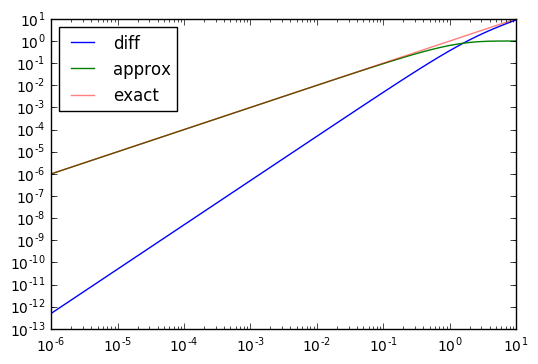

In [3]:
# sanity check on the Taylor expansion... the argument of the above equation must be <0.1
x = np.logspace(-6,1)
pl.loglog(x,(x-(1-np.exp(-x))), label='diff')
pl.loglog(x,(1-np.exp(-x)), label='approx')
pl.loglog(x,x, label='exact', alpha=0.5)
pl.legend(loc='best')

In [4]:
# density corresponding to 5-sigma
snu_dust(density=1.5e7*u.cm**-3).to(u.mJy)

10.020124131765304 solMass


<Quantity 0.562512697877883 mJy>

In [5]:
# density corresponding to TOO BRIGHT
snu_dust(density=3e8*u.cm**-3).to(u.mJy)

200.4024826353061 solMass


<Quantity 10.348417076652396 mJy>

In [6]:
Snu(Qlyc=1e47*u.s**-1, R=4000*u.au)

<Quantity 5.20733578908962 mJy>

In [7]:
Snu(Qlyc=1e47*u.s**-1, R=2000*u.au)

<Quantity 5.204189239191063 mJy>

In [8]:
Snu(Qlyc=1e46*u.s**-1, R=2000*u.au)

<Quantity 0.5207965403460448 mJy>

In [9]:
Snu(Qlyc=1e46*u.s**-1, R=100*u.au)

<Quantity 0.504400858149996 mJy>

In [10]:
# Quoted in paper
Snu(Qlyc=1e47*u.s**-1, R=100*u.au), np.log10(dens(R=100*u.au, Qlyc=1e47*u.s**-1).value)

(<Quantity 3.838631854301391 mJy>, 6.7760525794482742)

In [11]:
Snu(Qlyc=1e47*u.s**-1, R=50*u.au), np.log10(dens(R=50*u.au, Qlyc=1e47*u.s**-1).value)

(<Quantity 1.8661499583278558 mJy>, 7.2275975729442461)

In [12]:
# Quoted in paper (How small does the HII region have to be, and how dense, before O-stars can be hidden?)
Snu(Qlyc=1e47*u.s**-1, R=25*u.au), np.log10(dens(R=25*u.au, Qlyc=1e47*u.s**-1).value)

(<Quantity 0.5047970578821652 mJy>, 7.679142566440218)

In [13]:
Snu(Qlyc=1e48*u.s**-1, R=25*u.au), np.log10(dens(R=25*u.au, Qlyc=1e48*u.s**-1).value)

(<Quantity 0.5048137428036747 mJy>, 8.179142566440218)

In [14]:
Snu(Qlyc=1e46*u.s**-1, R=25*u.au), np.log10(dens(R=25*u.au, Qlyc=1e45*u.s**-1).value)

(<Quantity 0.32490574543415823 mJy>, 6.679142566440218)

In [15]:
dens(1e45*u.s**-1, R=0.1*u.pc)

<Quantity 201.56488712985856 1 / cm3>

In [16]:
# angular size in Sgr B2
distance = 8.4*u.kpc
R = (0.5*u.arcsec * distance).to(u.pc, u.dimensionless_angles())
print(R)

0.020362174606600513 pc


In [17]:
# observed limit (approx)
beam = radio_beam.Beam(0.5*u.arcsec)
cfreq = 95*u.GHz
(1*u.mJy).to(u.K, u.brightness_temperature(beam, cfreq))

<Quantity 0.541660174466252 K>

In [18]:
dens(1e45*u.s**-1, R=R)

<Quantity 2193.7071151512628 1 / cm3>

In [19]:
EM(1e45*u.s**-1, R=R)

<Quantity 97989.92943789548 pc / cm6>

In [20]:
Tb(EM=EM(1e45*u.s**-1, R=R))

<Quantity 0.025588840645629496 K>

In [21]:
Tb(EM=EM(1e46*u.s**-1, R=R))

<Quantity 0.2558841971417314 K>

In [22]:
Tb(EM=EM(1e47*u.s**-1, R=R))

<Quantity 2.558421090659513 K>

In [23]:
Tb_beamdiluted(Qlyc=np.logspace(45,50)*u.s**-1, R=1000*u.au)

<Quantity [  2.82108388e-02,  3.56823219e-02,  4.51324835e-02,
             5.70852774e-02,  7.22033632e-02,  9.13248046e-02,
             1.15509462e-01,  1.46097637e-01,  1.84784186e-01,
             2.33712167e-01,  2.95591139e-01,  3.73846536e-01,
             4.72808222e-01,  5.97948335e-01,  7.56181136e-01,
             9.56240639e-01,  1.20915569e+00,  1.52884673e+00,
             1.93287411e+00,  2.44337398e+00,  3.08822548e+00,
             3.90250037e+00,  4.93025437e+00,  6.22672578e+00,
             7.86101015e+00,  9.91927562e+00,  1.25085657e+01,
             1.57611955e+01,  1.98396687e+01,  2.49419012e+01,
             3.13063042e+01,  3.92159134e+01,  4.90001931e+01,
             6.10323570e+01,  7.57190078e+01,  9.34776706e+01,
             1.14696661e+02,  1.39671314e+02,  1.68512159e+02,
             2.01026107e+02,  2.36583664e+02,  2.74005165e+02,
             3.11524725e+02,  3.46910050e+02,  3.77803887e+02,
             4.02276069e+02,  4.19426217e+02,  4.297284

In [24]:
# 0.2 arcsec = FWHM / 2.35 = 0.5 / 2.35
r_unresolved = (0.2*u.arcsec*distance).to(u.cm, u.dimensionless_angles())
volume = (4/3.*np.pi*r_unresolved**3)
muh2 = 2.8*u.Da
dustdens_0pt5mJy = (dust.massofsnu(nu=cfreq, snu=0.5*u.mJy, temperature=40*u.K, distance=distance) / volume / muh2).to(u.cm**-3)
dustdens_10mJy = (dust.massofsnu(nu=cfreq, snu=10*u.mJy, temperature=40*u.K, distance=distance) / volume / muh2).to(u.cm**-3)
print("{0:g} {1:g}".format(dustdens_0pt5mJy,dustdens_10mJy))
print("column at 0.5 mJy: {0}".format(dust.colofsnu(nu=cfreq, snu_per_beam=0.5*u.mJy/beam, temperature=40*u.K)))
print("column at 10 mJy: {0}".format(dust.colofsnu(nu=cfreq, snu_per_beam=10*u.mJy/beam, temperature=40*u.K)))
print("tau at 0.5 mJy: {0}".format(dust.tauofsnu(nu=cfreq, snu_per_beam=0.5*u.mJy/beam, temperature=40*u.K)))
print("tau at 10 mJy: {0}".format(dust.tauofsnu(nu=cfreq, snu_per_beam=10*u.mJy/beam, temperature=40*u.K)))

5.70156e+07 1 / cm3 1.14058e+09 1 / cm3
column at 0.5 mJy: 8.446651114404672e+23 1 / cm2
column at 10 mJy: 1.8169314151426596e+25 1 / cm2
tau at 0.5 mJy: 0.0071975529850598335
tau at 10 mJy: 0.15482420137380976


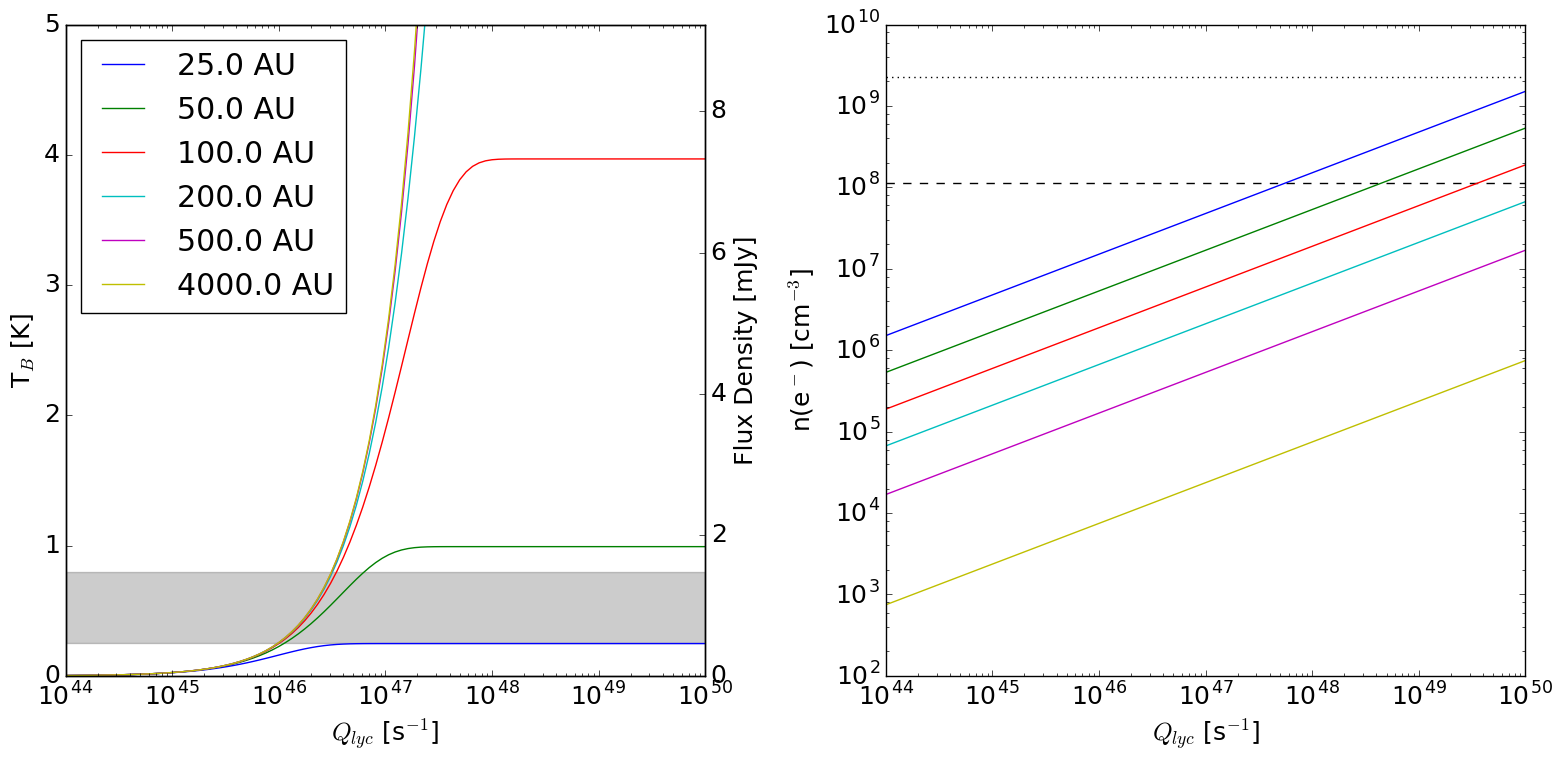

In [35]:
pl.figure(figsize=(16,8))
pl.rcParams['font.size']=18
ax1 = pl.subplot(1,2,1)
ax2 = pl.subplot(1,2,2)
Qlyc = np.logspace(44,50,100)*u.s**-1
beam_pc = (0.5*u.arcsec * distance).to(u.pc, u.dimensionless_angles())
for source_size in [25,50,100,200,500,4000]*u.au:
    tb = Tb_beamdiluted(Qlyc=Qlyc, R=source_size, beam=beam_pc)
    density = dens(Qlyc=Qlyc, R=source_size)

    ax1.semilogx(Qlyc, tb, label=source_size)
    ax2.loglog(Qlyc, density, label=source_size)
ax1.fill_between([Qlyc[0].value, Qlyc[-1].value],
                 [0.05*5]*2, [0.16*5]*2, color='k', alpha=0.2, zorder=-10)
ax1.legend(loc='best')
ax1twin = ax1.twinx()
ax1twin.set_ylim(0, (5*u.K).to(u.mJy, u.brightness_temperature(beam, cfreq)).value)
ax1twin.set_ylabel('Flux Density [mJy]')
ax1.set_ylim(0,5)
ax1.set_xlim(Qlyc.min().value, Qlyc.max().value)
ax2.set_xlim(Qlyc.min().value, Qlyc.max().value)
ax1.set_xlabel("$Q_{lyc}$ [s$^{-1}$]")
ax2.set_xlabel("$Q_{lyc}$ [s$^{-1}$]")
ax1.set_ylabel("T$_B$ [K]")
ax2.set_ylabel("n(e$^-$) [cm$^{-3}$]")
# multiply the N(H_2) densities by 2 to get to n(e)
ax2.hlines(dustdens_0pt5mJy.to(u.cm**-3).value*2, Qlyc[0].value, Qlyc[-1].value,color='k', linestyle='--')
ax2.hlines(dustdens_10mJy.to(u.cm**-3).value*2, Qlyc[0].value, Qlyc[-1].value,color='k', linestyle=':')

pl.tight_layout()
pl.savefig("/Users/adam/work/sgrb2/alma/figures/HII_region_brightness.png", bbox_inches='tight', dpi=150)

In [26]:
beam,source_size

(Beam: BMAJ=0.5 arcsec BMIN=0.5 arcsec BPA=0.0 deg, <Quantity 4000.0 AU>)

In [27]:
Tb_beamdiluted(Qlyc=Qlyc,R=0.1*u.pc, beam=0.2*u.pc)

<Quantity [ 0.00026524, 0.0003054 , 0.00035163, 0.00040487, 0.00046616,
            0.00053674, 0.000618  , 0.00071156, 0.00081929, 0.00094332,
            0.00108614, 0.00125057, 0.0014399 , 0.0016579 , 0.0019089 ,
            0.00219789, 0.00253065, 0.00291377, 0.0033549 , 0.00386282,
            0.00444763, 0.00512098, 0.00589628, 0.00678894, 0.00781676,
            0.00900017, 0.01036275, 0.01193162, 0.01373801, 0.01581787,
            0.01821261, 0.0209699 , 0.02414462, 0.02779998, 0.03200873,
            0.03685465, 0.04243421, 0.04885846, 0.05625529, 0.06477192,
            0.07457789, 0.08586836, 0.09886806, 0.11383575, 0.13106931,
            0.15091175, 0.17375795, 0.20006261, 0.23034917, 0.26522033] K>

In [28]:
Tb_beamdiluted(Qlyc=Qlyc,R=0.1*u.pc, beam=0.3*u.pc)

<Quantity [ 0.00011788, 0.00013573, 0.00015628, 0.00017994, 0.00020718,
            0.00023855, 0.00027467, 0.00031625, 0.00036413, 0.00041925,
            0.00048273, 0.00055581, 0.00063996, 0.00073684, 0.0008484 ,
            0.00097684, 0.00112473, 0.00129501, 0.00149107, 0.00171681,
            0.00197673, 0.00227599, 0.00262057, 0.00301731, 0.00347411,
            0.00400008, 0.00460567, 0.00530294, 0.00610578, 0.00703016,
            0.00809449, 0.00931995, 0.01073094, 0.01235555, 0.0142261 ,
            0.01637984, 0.01885965, 0.02171487, 0.02500235, 0.02878752,
            0.03314573, 0.03816371, 0.04394136, 0.05059367, 0.05825303,
            0.06707189, 0.07722576, 0.08891671, 0.10237741, 0.1178757 ] K>

In [29]:
Snu

<function __main__.Snu>